In [1]:
library(data.table)
library(ggplot2)
library(grid)
library(gridExtra)
library(gdata)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:data.table’:

    first, last

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith



In [2]:
df <- fread("/media/igna/Data/CRI_IA/Teacher_to_teacher/all_text_data.csv", header = T, sep = ',')

In [3]:
df[,comment_text:=tolower(comment_text)]
df[,forum_name:=tolower(forum_name)]
df[,topic_name:=tolower(topic_name)]
df[,date:=as.POSIXct(date_message)]
df[,year:=year(date)]
#isoweek: a week start on Monday
df[,week:=isoweek(date)]
df[,month:=month(date)]
df <- df[order(df$date),]

#Academic years are separated on July 31st
df$academic_year <- paste(df$year,df$year+1,sep="-")
df$academic_year[df$month<=7] <- paste(df$year-1,df$year,sep="-")[df$month<=7]

In [4]:
yrs <- sort(unique(df$year[df$week==1]))
for(yr in yrs){
    #Merging last and first week of the year
    #if first week of the year doesnt start on monday
    #Rq: no longer needed because isoweek for Jan 1st is 53 if Jan 1st is not a monday!
#    if(!weekdays(as.POSIXct(paste(yr,"-01-01",sep="")))%in%c('lundi','monday')){
        #then change the week number of the last year of the previous year (we input 1 instead)
#        df$week[df$week==isoweek(as.POSIXct(paste(yr-1,"-12-31",sep=""))) & df$year==yr-1] <- 1
#    }
    
    #Changing academic_year label for the beginning of august to have
    #Academic year starting on first monday after August 1st
    #if Aug 1st is not a monday
    if(!weekdays(as.POSIXct(paste(yr,"-08-01",sep=""))) %in% c("lundi","monday")){
        #then, we change the academic year for all the week including Aug 1st
        df$academic_year[df$year==yr & df$week==isoweek(as.POSIXct(paste(yr,"-08-01",sep="")))] <- 
            paste(df$year-1,df$year,sep="-")[df$year==yr & df$week==isoweek(as.POSIXct(paste(yr,"-08-01",sep="")))]
    }
}

In [5]:
#Week numbering to have first week of the academic year as nb 1:

df$yw <- paste(df$academic_year,df$week,sep="-")

df$ay_w <- NA

for(yr in unique(df$academic_year)){
    df$temp_wk <- NA
    df$temp_wk <- as.character(df$temp_wk)
    df$temp_wk[df$academic_year==yr] <- df$yw[df$academic_year==yr]
    df$temp_wk <- as.factor(df$temp_wk)
    df$temp_wk <- reorder(df$temp_wk,new.order = c(unique(df$yw[df$academic_year==yr])))
    levels(df$temp_wk) <- 1:length(unique(df$yw[df$academic_year==yr]))

    df$ay_w[df$academic_year==yr] <- as.character(df$temp_wk[df$academic_year==yr])
    }

#To be optimised...

In [6]:
#Year data
dy <- df[!duplicated(paste(df$academic_year, df$ay_w)),c("academic_year","ay_w","week")]

#### Holiday data
Data is available here
https://docs.google.com/spreadsheets/d/14GwlNQtkSr_hVF5essQPQW_vs-akhhHeAgYAPYmHK8c/edit#gid=0

manually copy-pasted from these websites (data is a mess to be scrapped, and its only one row per yar...)

https://vacances-scolaires.education/annee-2015-2016.php

We decided that for each holiday, 
- the "start" date correspond to a monday (monday for the first week of holiday)
- the "end" date correspond to a sunday
- the beginning of the year is a monday
- the end of the year is a monday (first week of summer holidays)

If holidays started on wednesdays or other days, we modified the start and end date in order to encompass the highest number of days if the holidays have started on monday and ended on sunday, and ensuring 2 weeks of holidays per holiday.

In [7]:
#Adding holidays
hol <- read.csv("/media/igna/Data/CRI_IA/Data_french_school_system/Holidays_France\ -\ Sheet1.csv")

In [8]:
y <- as.character(unlist(hol[,grep("_start",names(hol))]))
y <- y[y!=""]
unique(weekdays(as.POSIXct(y)))

y <- as.character(unlist(hol[,grep("_end",names(hol))]))
y <- y[y!=""]
unique(weekdays(as.POSIXct(y)))

[1] "lundi"

[1] "dimanche"

OK, all holidays start on monday and end on sunday

In [9]:
cbind(annee = as.character(hol$X[hol$Start!=""]),do.call('cbind',apply(hol[hol$Start!="",setdiff(names(hol),"X")],2,function(x){
    lapply(x,function(y){ifelse(y=="",NA,weekdays(as.POSIXct(y)))})
})))

annee     Start Toussaints_start Toussaints_end Noel_start Noel_end
13 2015-2016 mardi lundi            dimanche       lundi      dimanche
14 2016-2017 jeudi lundi            dimanche       lundi      dimanche
15 2017-2018 lundi lundi            dimanche       lundi      dimanche
   HiverA_start HiverA_end HiverB_start HiverB_end HiverC_start HiverC_end
13 lundi        dimanche   lundi        dimanche   lundi        dimanche  
14 lundi        dimanche   lundi        dimanche   lundi        dimanche  
15 lundi        dimanche   lundi        dimanche   lundi        dimanche  
   PrintempsA_start PrintempsA_end PrintempsB_start PrintempsB_end
13 lundi            dimanche       lundi            dimanche      
14 lundi            dimanche       lundi            dimanche      
15 lundi            dimanche       lundi            dimanche      
   PrintempsC_start PrintempsC_end End  
13 lundi            dimanche       lundi
14 lundi            dimanche       lundi
15 lundi            dimanche       lundi

Creating a database with "year-week" couples corresponding to holidays

In [10]:
hols <- sapply(strsplit(names(hol[grep("_start",names(hol))]),"_"),function(x){x[1]})
hols

[1] "Toussaints" "Noel"       "HiverA"     "HiverB"     "HiverC"    
[6] "PrintempsA" "PrintempsB" "PrintempsC"

In [45]:
dbhol <- data.frame()
for(h in hols){
    dbtemp <- data.frame(
        academic_year = hol$X[hol$Start!=""],
        holiday = rep(h,length(hol$X[hol$Start!=""])),
        week_start = isoweek(hol[hol$Start!="",paste0(h,"_start")]),
        week_ends  = isoweek(hol[hol$Start!="",paste0(h,"_end")]))
    dbhol <- rbind(dbhol,dbtemp)
    }

#Summer holidays
dbtemp <- data.frame(
        academic_year = hol$X[hol$Start!=""],
        holiday = rep("Summer1",length(hol$X[hol$Start!=""])),
        week_start = NA,
        week_ends  = isoweek(hol[hol$Start!="","Start"]))

dbhol <- rbind(dbhol,dbtemp)

dbtemp <- data.frame(
        academic_year = hol$X[hol$Start!=""],
        holiday = rep("Summer2",length(hol$X[hol$Start!=""])),
        week_start = isoweek(hol[hol$Start!="","End"]),
        week_ends  = NA)

dbhol <- rbind(dbhol,dbtemp)

In [46]:
dy_t <- dy

#Academic_year week for start of holidays
dy_t$week_start <- dy_t$week
#dy_t$week_ends <- dy_t$week
dbhol <- merge(dbhol,dy_t[,c("academic_year","week_start","ay_w")],all.x=TRUE)
dbhol$ay_week_start <- as.numeric(dbhol$ay_w)
dbhol$ay_w <- NULL

#Academic_year week for ending of holidays
dy_t$week_ends <- dy_t$week
dbhol <- merge(dbhol,dy_t[,c("academic_year","week_ends","ay_w")],all.x=TRUE)
dbhol$ay_week_ends <- as.numeric(dbhol$ay_w)
dbhol$ay_w <- NULL

#Summer holidays
dbhol$ay_week_start[dbhol$holiday=="Summer1"] <- 1
dbhol$ay_week_ends[dbhol$holiday=="Summer2"] <- 53

In [36]:
#Adding "holiday" tag to weeks in df database

#hol_week_year <- unlist(apply(hol[hol$Start!="",sort(c(grep("_start",names(hol)),
#                                                       grep("_end",names(hol))))],2,function(x){
#    paste(as.character(hol$X[hol$Start!=""]),sapply(x,function(y){ifelse(y=="",NA,isoweek(as.POSIXct(y)))}),sep="-")
#                }))

#df$holiday <- FALSE
#df$holiday_name <- NA

#for(h in hols){
#    df$holiday[df$yw%in%c(as.character(unlist(hol_week_year[,paste0(h,"_start")])),
#                          as.character(unlist(hol_week_year[,paste0(h,"_end")])))] <- TRUE
#    df$holiday_name[df$yw%in%c(as.character(unlist(hol_week_year[,paste0(h,"_start")])),
#                               as.character(unlist(hol_week_year[,paste0(h,"_end")])))] <- h    
#}

**To do:**
- doing such "institutional dates" preprocessing separately
- Adding to the query the forum name and issue
- Adding to the plot the moment of the year and the holiday dates each year
- starting "academic year count" based on holidays for all years
- see what to do with overlapping holidays (HiverA, B and C...)

In [32]:
#Total number of posts in the given week
dall <- as.data.frame(df[,.N, by=.(academic_year,ay_w)])

In [132]:
yrs <- as.character(unique(dall$academic_year))

In [141]:
colfunc <- colorRampPalette(c("#ffff00", "#ff0000"))

In [133]:
mot <- "math"

In [165]:
plotting_trend <- function(mot){

    #Conducting query in the database
    dchs <- as.data.frame(df[comment_text %like% mot | 
                             topic_name %like% mot |
                             forum_name %like% mot,.N, by=.(academic_year,ay_w)])
    dfs <- as.data.frame(df[forum_name %like% mot,.N, by=.(academic_year,ay_w)])

    #Merging data of query and overall number of posts
    dpl <- merge(x = dall, y = dchs, by = c("academic_year","ay_w"), all.x = TRUE)
    dpl <- merge(x = dpl, y = dfs, by = c("academic_year","ay_w"), all.x = TRUE)
    dpl <- merge(x = dpl, y = dy, by = c("academic_year","ay_w"), all.x = TRUE)
    names(dpl) <- c("academic_year","ay_week","Ntot","Ncomm","Nforum","week")

    #Evaluating proportions of posts
    dpl$Ncomm[is.na(dpl$Ncomm)] <- 0
    dpl$Nforum[is.na(dpl$Nforum)] <- 0
    dpl$prop_comm <- 100*dpl$Ncomm/dpl$Ntot
    dpl$prop_forum <- 100*dpl$Nforum/dpl$Ntot

    dpl$week <- as.numeric(dpl$week)
    dpl$ay_week <- as.numeric(dpl$ay_week)
    
    #PLOT
    p <- ggplot()
    #Adding holidays
    p <- p + geom_rect(data=dbhol[dbhol$academic_year=="2015-2016",], aes(xmin = ay_week_start-1, 
                                                                   xmax = ay_week_ends,
                                                                   ymin = 0,
                                                                   ymax = 100),fill = "lightgray",
                       show.legend=FALSE)

    #Adding legends for holidays
    p <- p + geom_text(data=dbhol[dbhol$academic_year=="2015-2016" & 
                                  !1:nrow(dbhol)%in%c(grep("A",dbhol$holiday),
                                                      grep("C",dbhol$holiday)),],
                       aes(x = ay_week_start,y = 100,label = holiday))

    #Adding data for years in yrs (i.e. years for which we have holiday data)
    p <- p + geom_line(data=dpl[dpl$academic_year%in%yrs,],aes(x=ay_week,y=prop_comm, color = academic_year)) 
    p <- p + scale_color_manual(values = c(colfunc(length(yrs))))

    p <- p + ylim(0,102)
    
    return(list(data = dpl,plt = p))
    
    }

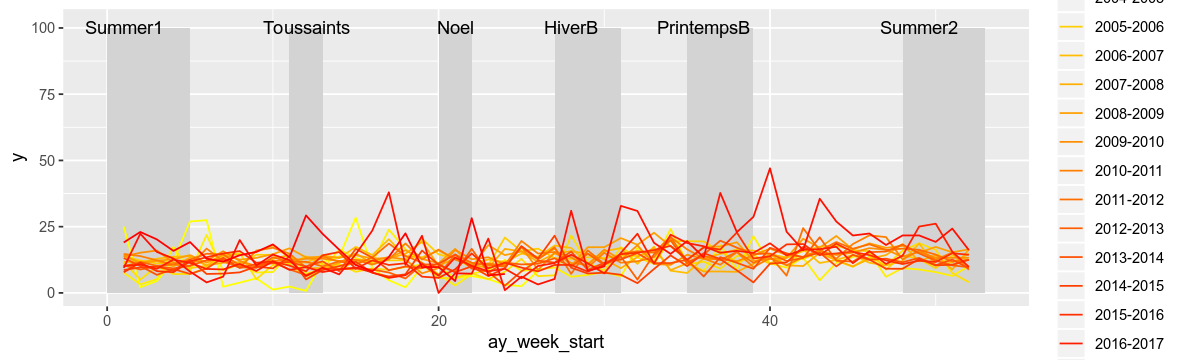

In [166]:
options(repr.plot.width=10, repr.plot.height=3)
L <- plotting_trend("math")
L$plt

In [169]:
data <- L$data
data[data$prop_comm>40,]

,academic_year,ay_week,Ntot,Ncomm,Nforum,week,prop_comm,prop_forum
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
789,2017-2018,40,287,135,130,19,47.03833,45.29617


Rapport Villani Torossian (published on Feb 2018)

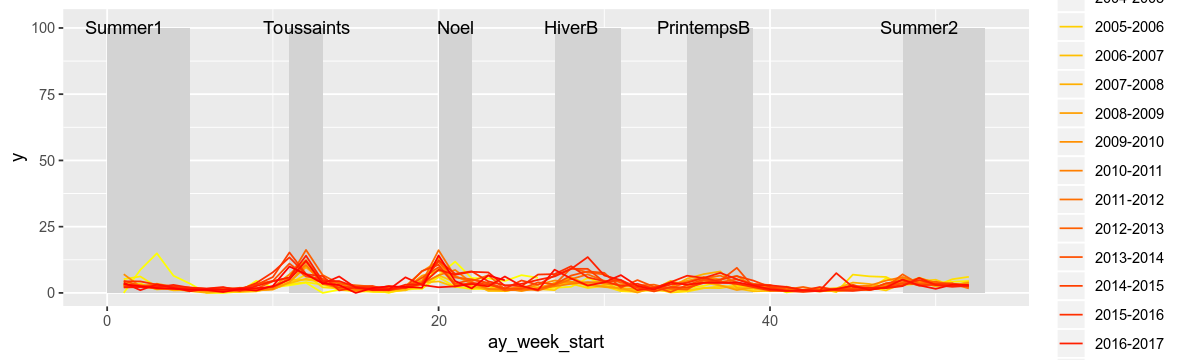

In [171]:
options(repr.plot.width=10, repr.plot.height=3)
L <- plotting_trend("vacance")
L$plt

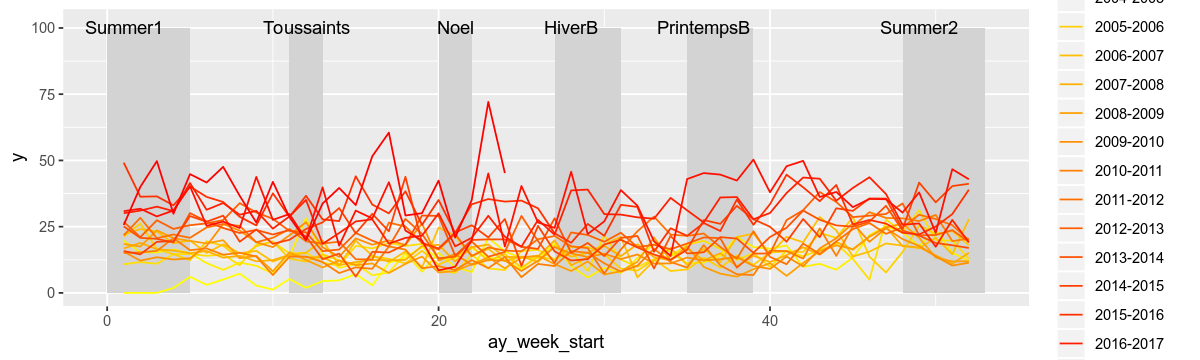

In [172]:
options(repr.plot.width=10, repr.plot.height=3)
L <- plotting_trend("\\bcp")
L$plt

In [173]:
data <- L$data
data[data$prop_comm>50,]

,academic_year,ay_week,Ntot,Ncomm,Nforum,week,prop_comm,prop_forum
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
787,2017-2018,39,324,163,0,18,50.30864,0
814,2018-2019,16,221,114,0,47,51.58371,0
815,2018-2019,17,162,98,0,48,60.49383,0
822,2018-2019,23,197,142,0,2,72.08122,0


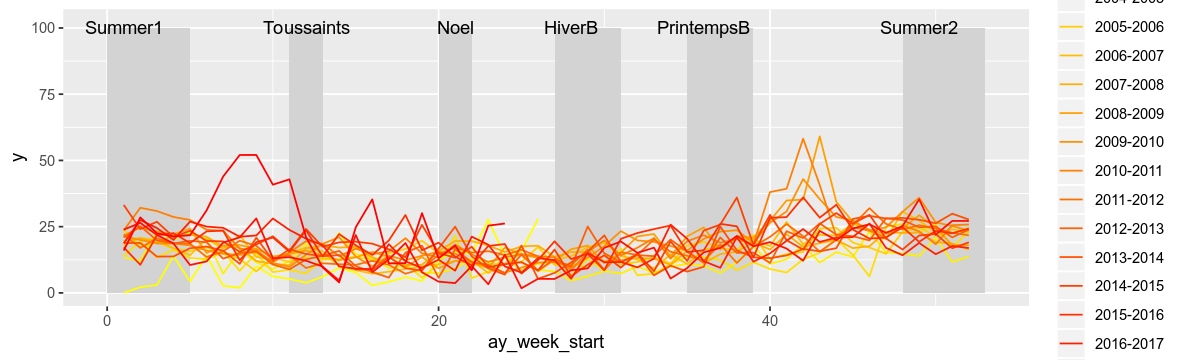

In [174]:
options(repr.plot.width=10, repr.plot.height=3)
L <- plotting_trend("\\ce1")
L$plt

In [175]:
data <- L$data
data[data$prop_comm>50,]

,academic_year,ay_week,Ntot,Ncomm,Nforum,week,prop_comm,prop_forum
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
324,2008-2009,43,1393,823,0,22,59.08112,0
427,2010-2011,42,1268,738,0,20,58.20189,0
829,2018-2019,8,415,216,0,39,52.04819,0
830,2018-2019,9,459,239,0,40,52.06972,0


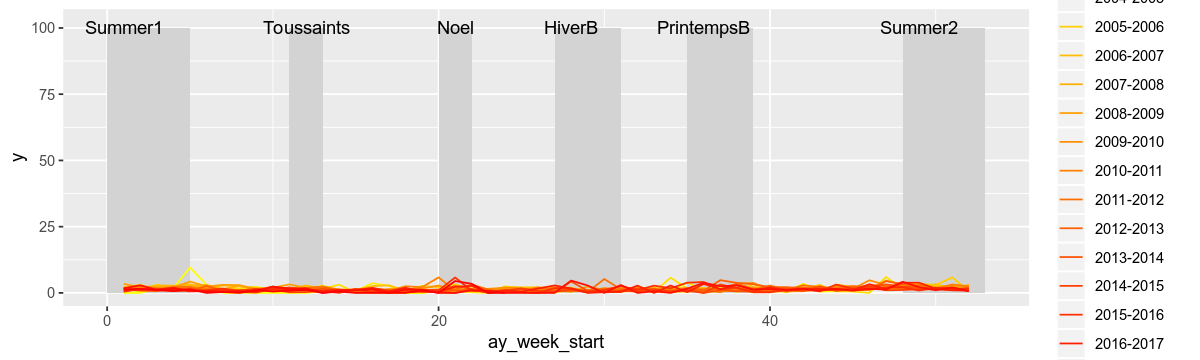

In [185]:
options(repr.plot.width=10, repr.plot.height=3)
L <- plotting_trend("g(e|é)om(e|é)tr")
L$plt

In [122]:
YR <- seq(min(df$year),max(df$year))
MT <- paste(sapply(seq(1:12),function(x){ifelse(x<10,paste0("0",x),as.character(x))}),"01",sep="-")
data_year <- data.frame(year = rep(YR,each=length(MT)),
                        month = rep(seq(1:12),times=length(YR)),
                        date = as.POSIXct(paste(rep(YR,each=length(MT)),rep(MT,times=length(YR)),sep="-")))
data_year$week <- week(data_year$date)
data_year$weekday <- weekdays(data_year$date)
data_year$academic_year <- paste(data_year$year,data_year$year+1,sep="-")
data_year$academic_year[data_year$month<=7] <- paste(data_year$year-1,data_year$year,sep="-")[data_year$month<=7]

In [123]:
data_year$weekday <- as.factor(data_year$weekday)
data_year$weekday <- reorder(data_year$weekday, new.order = c("lundi","mardi","mercredi",
                                                               "jeudi","vendredi","samedi","dimanche"))
data_year$weekday_nb <- as.numeric(data_year$weekday) - 1

In [124]:
data_year$weekday_relative <- data_year$week - data_year$weekday_nb/7

In [125]:
head(data_year[data_year==2004,])

,year,month,date,week,weekday,academic_year,weekday_nb,weekday_relative
,<int>,<int>,<dttm>,<int>,<fct>,<chr>,<dbl>,<dbl>
13,2004,1,2004-01-01,1,jeudi,2003-2004,3,0.5714286
14,2004,2,2004-02-01,5,dimanche,2003-2004,6,4.1428571
15,2004,3,2004-03-01,9,lundi,2003-2004,0,9.0000000
16,2004,4,2004-04-01,14,jeudi,2003-2004,3,13.5714286
17,2004,5,2004-05-01,18,samedi,2003-2004,5,17.2857143
18,2004,6,2004-06-01,22,mardi,2003-2004,1,21.8571429


In [129]:
data_year[data_year$academic_year==yr_i,]

,year,month,date,week,weekday,academic_year,weekday_nb,weekday_relative
,<int>,<int>,<dttm>,<int>,<fct>,<chr>,<dbl>,<dbl>
32,2005,8,2005-08-01,31,lundi,2005-2006,0,31.0000000
33,2005,9,2005-09-01,35,jeudi,2005-2006,3,34.5714286
34,2005,10,2005-10-01,40,samedi,2005-2006,5,39.2857143
35,2005,11,2005-11-01,44,mardi,2005-2006,1,43.8571429
36,2005,12,2005-12-01,48,jeudi,2005-2006,3,47.5714286
37,2006,1,2006-01-01,1,dimanche,2005-2006,6,0.1428571
38,2006,2,2006-02-01,5,mercredi,2005-2006,2,4.7142857
39,2006,3,2006-03-01,9,mercredi,2005-2006,2,8.7142857
40,2006,4,2006-04-01,14,samedi,2005-2006,5,13.2857143


In [131]:
options(repr.plot.width=10, repr.plot.height=3)
yr_i <- "2005-2006"
p <- ggplot(data=dpl[dpl$academic_year==yr_i,],aes(x=week,y=prop_forum)) + geom_line()
p <- p + scale_x_continuous(breaks = data_year$weekday_relative[data_year$academic_year==yr_i],
                            labels = rep("",length(month.abb)))

#p <- p + geom_text(x=data_year$week[data_year$year==yr_i]+2, y=0, label=month.abb)
p <- p + annotate(geom = "text", x = data_year$weekday_relative[data_year$academic_year==yr_i]+2, y = 0, 
                  label = month.abb[data_year$month[data_year$academic_year==yr_i]])
p <- p + ylim(0,25)

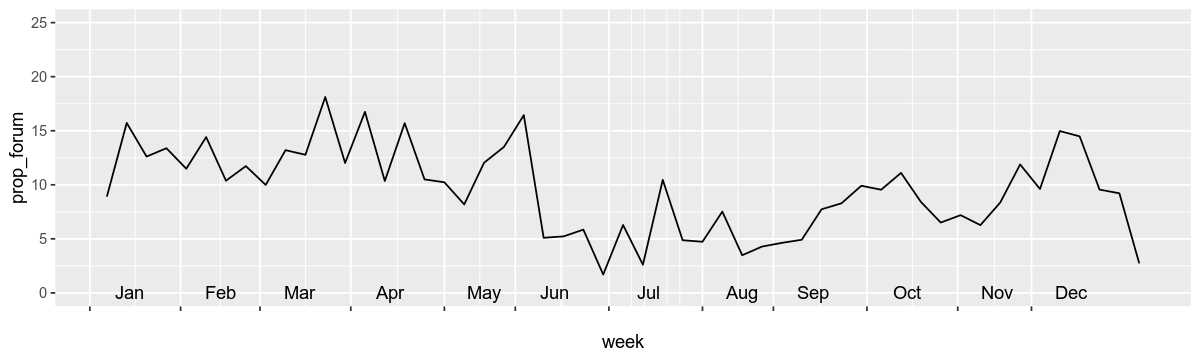

In [132]:
p

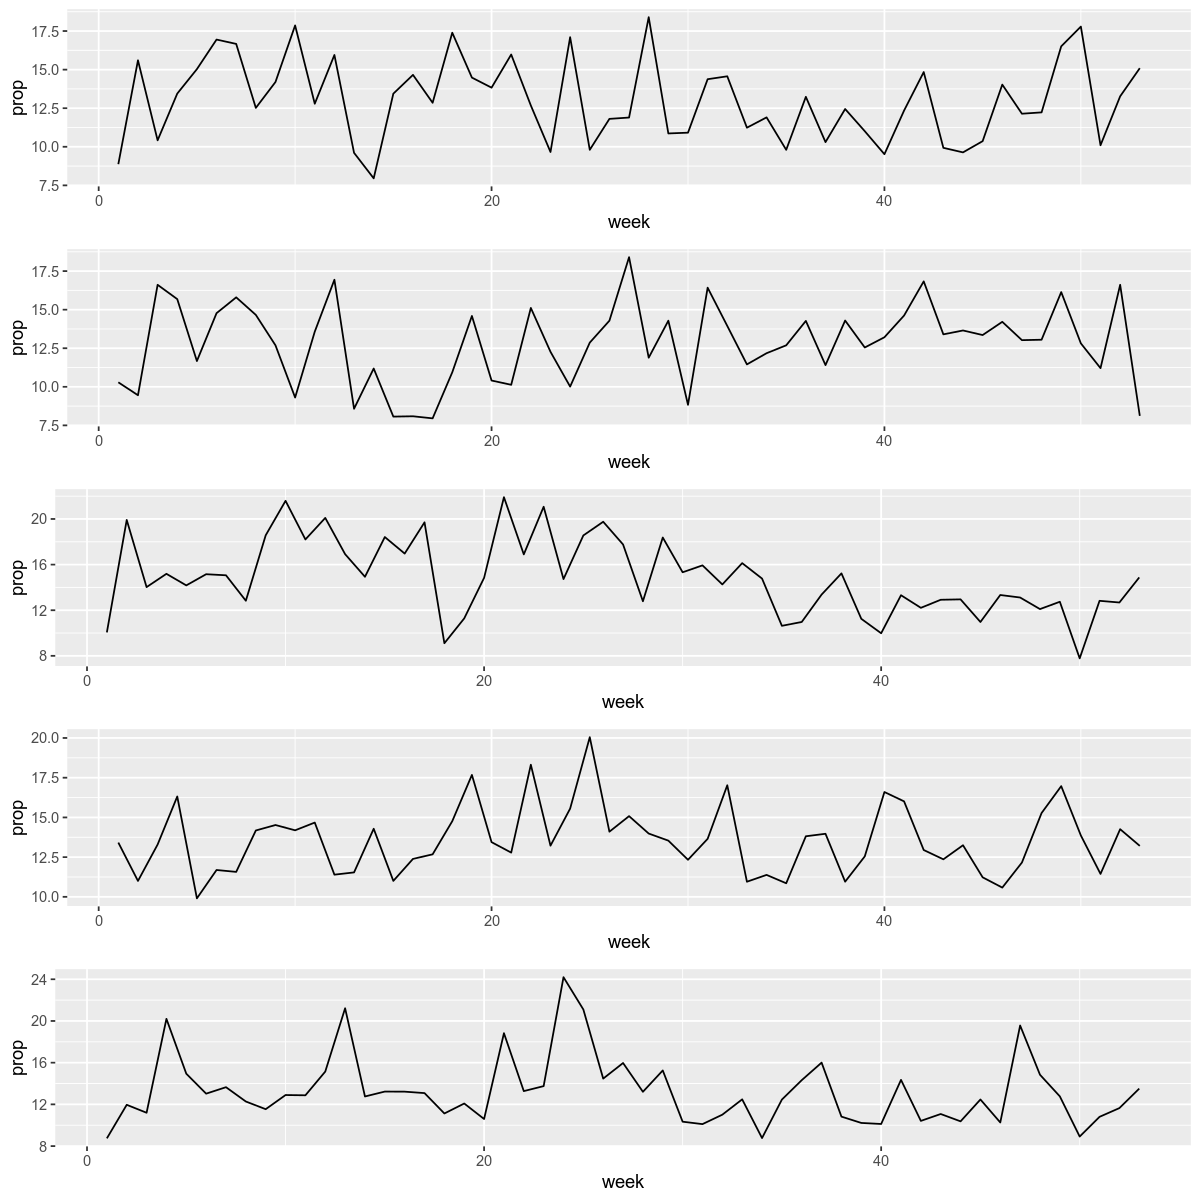

In [14]:
options(repr.plot.width=10, repr.plot.height=10)

p <- ggplot(data=dpl[dpl$year==2007,],aes(x=week,y=prop)) + geom_line()

grid.arrange(
    ggplot(data=dpl[dpl$year==2007,],aes(x=week,y=prop)) + geom_line(),
    ggplot(data=dpl[dpl$year==2008,],aes(x=week,y=prop)) + geom_line(),
    ggplot(data=dpl[dpl$year==2009,],aes(x=week,y=prop)) + geom_line(),
    ggplot(data=dpl[dpl$year==2010,],aes(x=week,y=prop)) + geom_line(),
    ggplot(data=dpl[dpl$year==2011,],aes(x=week,y=prop)) + geom_line(),
    ncol=1)

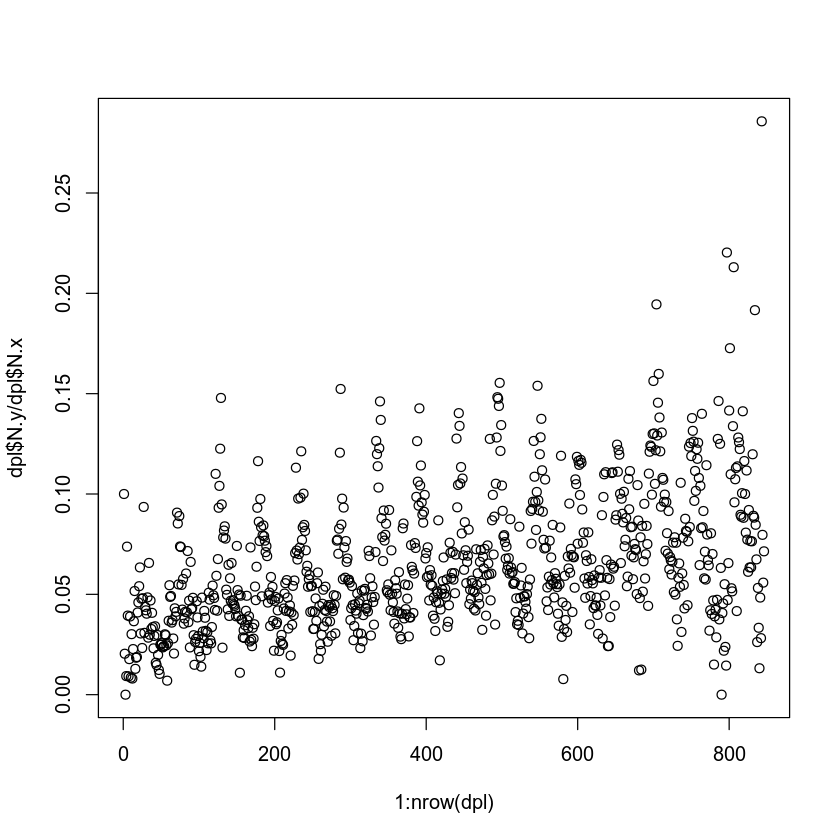

In [19]:
plot(1:nrow(dpl),dpl$N.y/dpl$N.x)

In [8]:
dim(df[comment_text %like% "math",])

[1] 45384    11

In [24]:
head(df[comment_text %like% "math",])

V1,author,comment_text,date_message,nb_messages,quoted_people,quoted_text,references,forum_name,topic_name,url_page,date,year,week
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<int>,<int>
0,blanc78,"['bonjour ', 'je cherche une séance de depart pour introduire la representation des nombres sur une droite graduée : dans pour comprendre les maths, il propose par un schema de faire faire le lien entre bande numérique et droite graduée en reportant au fur et à mesure des bandes de nombres de plus en plus grandes (ex : reporter 1, puis, 1 2 3...etc.) comment avez -vous fait ? ', 'merci']",2010-02-23T16:46:05Z,18 messages,[],[],[],Mathématiques,la droite graduée au ce1,https://forums-enseignants-du-primaire.com/topic/218867-la-droite-gradu%C3%A9e-au-ce1/?page=1,2010-02-23,2010,8
2,elodieh,"[""""moi aussi je vais commencer la symétrie vendredi ca m'interesse aussi..."""", """"même si je pense commencer par des pliages et découpage afin d'observer une symétrie par rapport à l'axe du plie?"""", 'est ce plus simple avec du calque?', 'ou peut-on directement montrer des figures papiers quadrillés et rechercher des axes de symétrie? (on peut les reproduire, les découper et les plier...)', 'bref, je suis encore dans le flou... comme toujours en maths!', """"si tu as plus d'idée yaka hésites pas ^^""""]",2010-02-21T11:39:24Z,73 messages,[],[],[],Mathématiques,Symétrie au cm1,https://forums-enseignants-du-primaire.com/topic/218033-sym%C3%A9trie-au-cm1/?page=1,2010-02-21,2010,8
33,Patty54,"['bonjour, ', """"je me pose une question concernant les tables de multiplication au ce1 : ds mon fichier de maths la table de 5 est abordée avec la table de 10, hors la table de 10 n'est pas mentionnée ds les programmes."""", """"qu'en pensez- vous?"""", 'merci par avance!']",2010-02-20T10:24:44Z,95 messages,[],[],[],Mathématiques,table de 5 et de 10 au ce1?,https://forums-enseignants-du-primaire.com/topic/218656-table-de-5-et-de-10-au-ce1/?page=1,2010-02-20,2010,8
57,Betstan,"['bonsoir,', 'je voulais savoir où vous en étiez du cap maths ce1 version 2008 et du cap maths ce2 manuel...', """"perso, en ce1, les élèves ont fait l'éval de l'unité 7 aujourd'hui (je n'ai jamais fait les pages problèmes de la fin...) et en ce2, ils en sont à la séance 5 ou 6 de l'unité 7..."""", """"merci d'avance pour vos réponses.""""]",2010-02-11T19:51:44Z,95 messages,[],[],[],Mathématiques,Où en êtes-vous? Cap maths CE1 CE2,https://forums-enseignants-du-primaire.com/topic/218113-o%C3%B9-en-%C3%AAtes-vous-cap-maths-ce1-ce2/?page=1,2010-02-11,2010,7
58,vansquale,"[""""je fais la séance 5 de l'unité 7 demain avec mes ce1."""", """"c'est vrai que ça avance lentement mais ça ne sert à rien de se précipiter"""", 'si les notions ne sont pas assimilées par les élèves. il faut donc adapter ', 'les séances (très riches) ainsi que les exercices afin que les élèves y arrivent.', """"dans ma classe il n'y a ni fichier ni manuel de maths donc ce n'est pas un problème """", """"car parfois je trouve que certains exercices s'éloignent trop des activités de"""", 'manipulation ce qui perd les gamins.']",2010-02-11T20:14:18Z,150 messages,[],[],[],Mathématiques,Où en êtes-vous? Cap maths CE1 CE2,https://forums-enseignants-du-primaire.com/topic/218113-o%C3%B9-en-%C3%AAtes-vous-cap-maths-ce1-ce2/?page=1,2010-02-11,2010,7
59,luccia,"[""""avec mes ce2 j'en suis à la séance 2 de l'unite 8."""", """"par contre à côté, j'ai déjà abordé la soustraction à retenue ainsi que la multiplication à 2 chiffres car je trouve que ça tarde dans cap math et ils étaient prêts."""", """"mais j'ai un super groupe de ce2, très travailleur et demandeur.""""]",2010-02-11T20:42:10Z,1 138 messages,[],[],[],Mathématiques,Où en êtes-vous? Cap maths CE1 CE2,https://forums-enseignants-du-primaire.com/topic/218113-o%C3%B9-en-%C3%AAtes-vous-cap-maths-ce1-ce2/?page=1,2010-02-11,2010,7


In [11]:
head(df$date_message)

[1] "2010-02-23T16:46:05Z" "2010-02-10T17:36:40Z" "2010-02-21T11:39:24Z"
[4] "2010-02-21T11:52:19Z" "2010-02-21T17:16:09Z" "2010-02-22T11:03:59Z"

In [14]:
as.POSIXct(head(df$date_message))

[1] "2010-02-23 CET" "2010-02-10 CET" "2010-02-21 CET" "2010-02-21 CET"
[5] "2010-02-21 CET" "2010-02-22 CET"

In [15]:
df[,date:=as.POSIXct(date_message)]

In [16]:
head(df$date)

[1] "2010-02-23 CET" "2010-02-10 CET" "2010-02-21 CET" "2010-02-21 CET"
[5] "2010-02-21 CET" "2010-02-22 CET"

In [20]:
strftime(head(df$date),format="%Y-%W")

 chr [1:6] "2010-08" "2010-06" "2010-07" "2010-07" "2010-07" "2010-08"


In [22]:
head(week(df$date))

[1] 8 6 8 8 8 8

In [23]:
df[,year:=year(date)]
df[,week:=week(date)]